In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

In [154]:
from keras import backend as K
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from keras import initializers, regularizers, constraints, optimizers, layers

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

from lib.config import Config
import lib.embedding_utils as utils
from lib.metrics_plotter import MetricsPlotter
from lib.model_utils import random_index, ToxicCommentPredictionPrinter, to_input

In [3]:
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

https://www.kaggle.com/jhoward/improved-lstm-baseline-glove-dropout

## Load train and test datasets

In [4]:
config = Config('./config.yml')

In [5]:
train = pd.read_csv(config['dataset.path.train'])
train_comments = train[config['dataset.features'][0]].fillna("_na_").values
train_labels = train[config['dataset.labels']].values

In [6]:
test = pd.read_csv(config['dataset.path.test'])
test_samples = test[config['dataset.features'][0]].fillna("_na_").values

In [7]:
train_samples, validation_samples, train_labels, validation_labels = train_test_split(
    train_comments, 
    train_labels,
    test_size=0.2
)
print("Train (Samples:",  len(train_samples), ", Labels:", len(train_labels), ")")
print("Validation (Samples: ", len(validation_samples), ", Labels:", len(validation_labels), ")") 

Train (Samples: 127656 , Labels: 127656 )
Validation (Samples:  31915 , Labels: 31915 )


In [8]:
print(f'Comment:{train_samples[49]}')
print(f'Categories: {train_labels[49]}')

Comment:It wasn't me that edited those pages. http://urdirt.com/2009/10/01/ufc-108-silva-vs-belfort-rumors/ Its UFC 108: Silva vs. Belfort until further notice now please leave it alone and have a nice day.
Categories: [0 0 0 0 0 0]


Create a tokenizer

In [9]:
tokenizer = Tokenizer(num_words=config['word_embeding.rows_count'])
tokenizer.fit_on_texts(list(train_samples) + list(validation_samples) + list(test))

A tokenization convert comments to sequence of word indexes. It aboint to:
* Get an array of unrepeted words taken of all comments.
* Replace each word under a comments to his index.
* As result each comment is tranformed to an array of word indexes.

In [10]:
tokenized_train_samples = tokenizer.texts_to_sequences(train_samples)
tokenized_validation_samples = tokenizer.texts_to_sequences(validation_samples)
tokenized_test_samples = tokenizer.texts_to_sequences(test_samples)

In [11]:
print("First train comment sequence:\n\t", tokenized_train_samples[0])
print("First val comment sequence:\n\t", tokenized_validation_samples[0])

First train comment sequence:
	 [73, 263, 73, 50, 177, 37, 132, 4217, 4, 10644, 143, 166, 15, 1, 858, 9, 22, 7, 72, 240, 36, 73, 1242, 2, 124, 4204, 2, 1, 23]
First val comment sequence:
	 [161, 3333, 73, 1242, 2, 391, 60, 3378, 2, 3844, 1, 3870, 26, 1, 4303, 882, 8, 128, 7, 40, 452, 5, 2835, 3923, 3870, 25, 713, 3, 53, 40, 83, 16, 3388, 10, 25, 60, 61, 7693, 7088, 262, 2, 2660, 916, 974]


Next is necessary take each comment sequence and complet with zeros up to fixes size. As result all comment sequences have same len.

In [12]:
paded_train_samples = pad_sequences(
    tokenized_train_samples, 
    maxlen=config['word_embeding.columns_count']
)

In [13]:
paded_validation_samples = pad_sequences(
    tokenized_validation_samples, 
    maxlen=config['word_embeding.columns_count']
)

In [14]:
paded_test_samples = pad_sequences(
    tokenized_test_samples, 
    maxlen=config['word_embeding.columns_count']
)

In [15]:
print("First train fixed size comment sequence:\n\t", paded_train_samples[0])

First train fixed size comment sequence:
	 [    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0    73   263    73
    50   177    37   132  4217     4 10644   143   166    15     1   858
     9    22     7    72   240    36    73  1242     2   124  4204     2
     1    23]


In [16]:
embedding_matrix = utils.build_embedding_matrix(
    embedding_file=config['word_embeding.path'],
    rows_count=config['word_embeding.rows_count'],
    columns_count=config['word_embeding.columns_count'],
    word_index=tokenizer.word_index
)

/home/adrian/development/machine-learning/toxic-comments/lib/embedding_utils.py:17: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  all_embs = np.stack(embedding_vectors)


In [17]:
print("Word embedding shape: ", embedding_matrix.shape)

Word embedding shape:  (20000, 50)


In [18]:
print("Unrepeated words from all comments: ", len(tokenizer.word_index))

Unrepeated words from all comments:  210337


In [19]:
class ToxicCommentPredictor:
    def __init__(self, config, embedding_matrix):
        _input = Input(shape=(config['word_embeding.columns_count'],))

        net = Embedding(
            config['word_embeding.rows_count'],
            config['word_embeding.columns_count'],
            weights=[embedding_matrix],
            trainable=True
        )(_input)

        net = Bidirectional(
            LSTM(
                config['word_embeding.columns_count'], 
                return_sequences=True, 
                dropout=0.2,
                recurrent_dropout=0.05
            )
        )(net)

        net = GlobalMaxPool1D()(net)
        net = Dense(512, activation="relu")(net)
        net = Dropout(0.2)(net)
        output = Dense(6, activation="sigmoid")(net)

        model = Model(inputs=_input, outputs=output)

        optimizer = optimizers.adam(lr=0.0001)

        model.compile(
            loss='binary_crossentropy', 
            optimizer=optimizer,
            metrics=['accuracy']
        )

        self.__model = model

        self.__callbacks = [
            ModelCheckpoint(
                filepath='best_weights.hdf5', 
                verbose=1,
                save_best_only=True
            ),
            MetricsPlotter(
                validation_data=(paded_validation_samples, validation_labels),
                plot_interval=600,
                evaluate_interval=600,
                batch_size=32
            )
        ]

    def fit(self, samples, labels, validation_samples, validation_labels):
        self.__model.fit(
            samples,
            labels,
            batch_size=32,
            epochs=2,
            validation_data=(validation_samples, validation_labels),
            verbose=1,
            callbacks=self.__callbacks
    )
        
    def predict_one(self, sample): return self.predict_many(to_input(sample))
    
    def predict_many(self, samples): return self.__model.predict(samples, batch_size=32)
    
    def summary(self): self.__model.summary()
        
    def load(self, path): self.__model.load_weights(path)


In [20]:
model = ToxicCommentPredictor(config, embedding_matrix)
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 50)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 50, 50)            1000000   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 50, 100)           40400     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               51712     
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 3078      
Total para

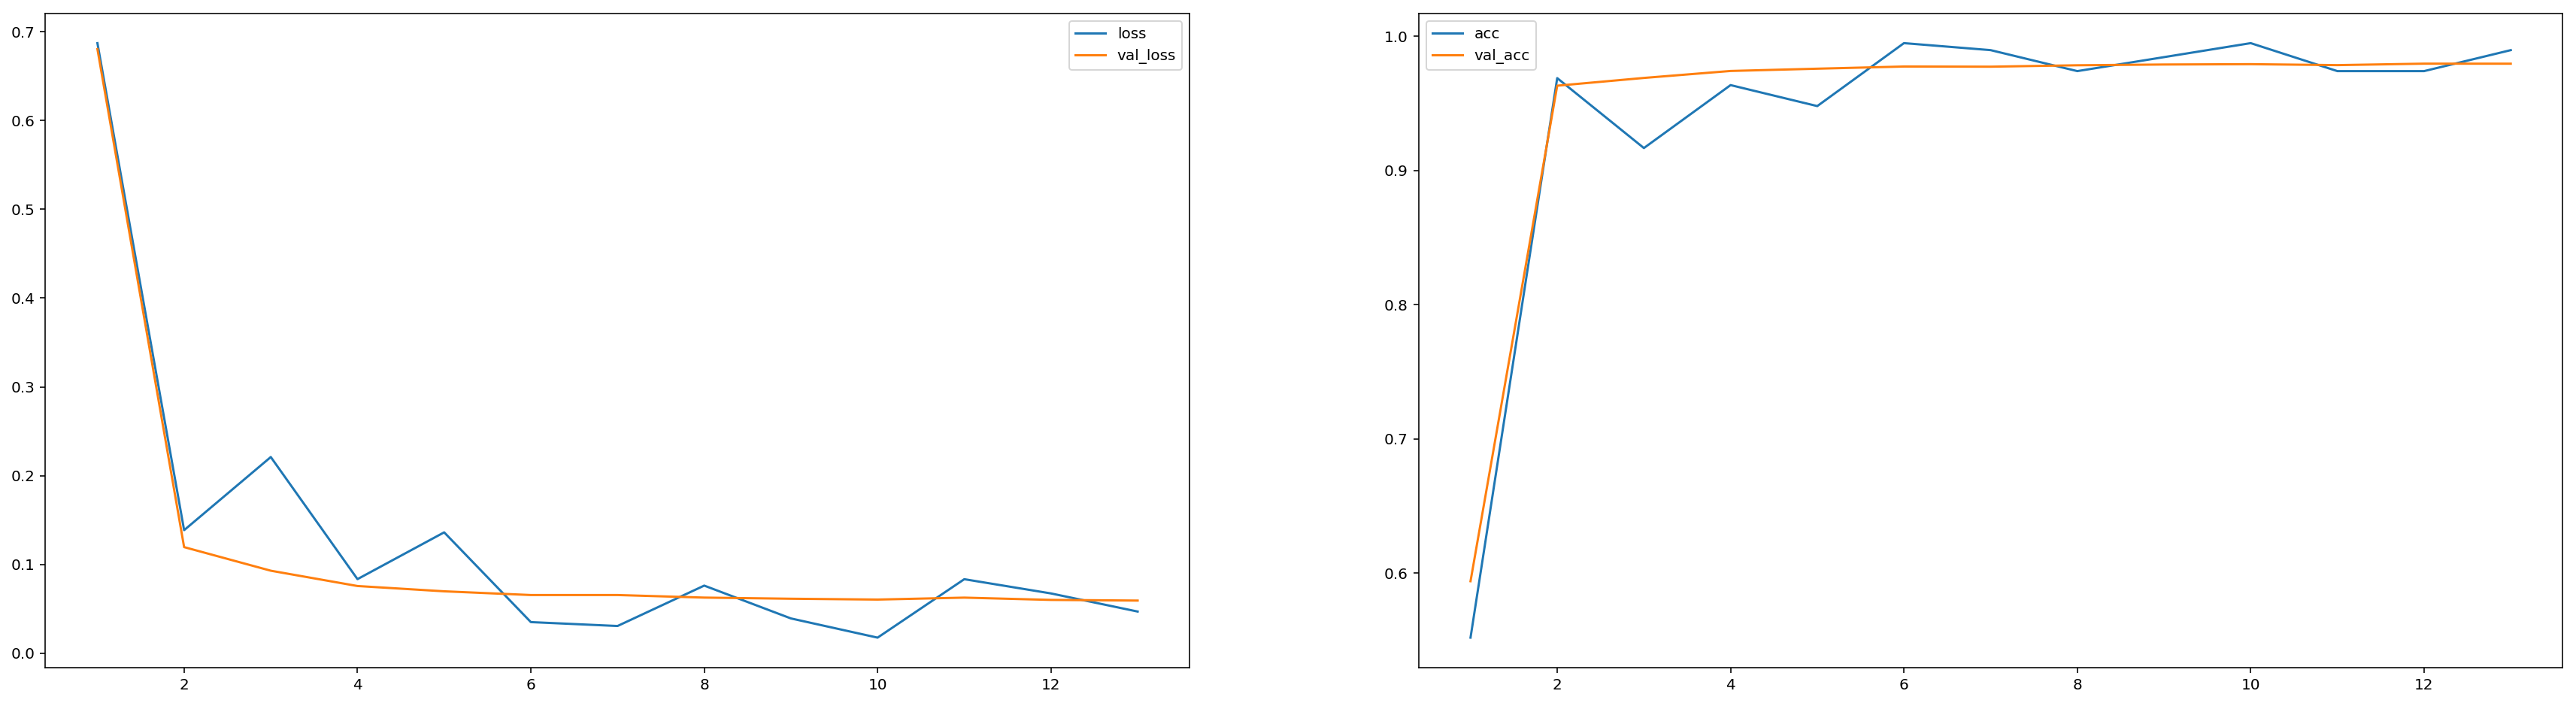

31915/31915 [==============================] - 30s 948us/step

Validation:
  - Loss (14): 0.058008 (⟱ 0.00124446)
  - Acc (14): 0.979660 (⟰ 0.00017755)
127656/127656 [==============================] - 644s 5ms/step - loss: 0.0623 - acc: 0.9787 - val_loss: 0.0588 - val_acc: 0.9793

Epoch 00002: val_loss improved from 0.06264 to 0.05876, saving model to best_weights.hdf5


In [21]:
model.fit(paded_train_samples, train_labels, paded_validation_samples, validation_labels)

Test model:

In [21]:
model.load('best_weights.hdf5')

In [155]:
printer = ToxicCommentPredictionPrinter(model, tokenizer, config, paded_test_samples)

In [156]:
printer.print_any()

Comment (idx:149780) => Don't suppose you fancy drafting that here for all to see s trying to it from various places in this saga is a bit.

Categories =>  ['toxic(32.0%)']
